<h1><center>Hito 6</center></h1>

<h1><center>Impacto del jitter</center></h1>

&nbsp;

<center>
Álvaro Garcı́a Garcı́a<br>
Álvaro José Martı́nez Sánchez<br>
José Francisco Castillo Berenguel<br>
</center>
    
    
<hr style="border:1px solid gray"> </hr>


# Introducción

Se ha estudiado en el hito 4 la influencia que tiene el tamaño de chunk en la latencia. En el hito 5 se puso de manifiesto la construcción de un programa intercom que permitiera la transmisión de audio. Por este motivo, resulta relevante el estudio de la latencia que genera la red, ya que, la latencia total $t_u$ viene dada por:

$$t_u=t_p+t_i$$

donde $t_p$ es el <i>tiempo de propagación</i> y $t_i$ es el la latenica generada por intercom.

El objetivo de este hito es medir la <i>calidad de experiencia</i> (QoE).

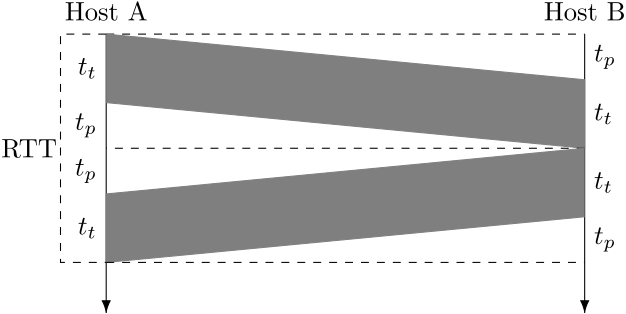

# Caracterización de la latencia en distintos escenarios

Se procde con el estudio de la latencia tanto a nivel local como a nivel remoto

## Caracterización de la latencia local

In [3]:
!ping localhost -c 100 -s 512 > /tmp/ping-512b.dat

In [365]:
!ping localhost -c 100 -s 512 > /tmp/ping-64b.dat

Se calcula la latencia esperada, teniendo en cuanta que el $RTT$ es el doble total de la altencia 

In [369]:
!export LC_NUMERIC=en_US.UTF-8
! grep from < /tmp/ping-64b.dat | cut -f 4 -d "=" | cut -f 1 -d " " | awk '{print $1/2}' > /tmp/localhost_latencies.dat


Se calcula el histograma de las latencias esperadas

In [368]:
import numpy as np 
from scipy import stats 
latencies = np.loadtxt("/tmp/localhost_latencies.dat") 
average_latency = np.average(latencies) 
print("average latency =", average_latency) 
max_latency = np.max(latencies) 
min_latency = np.min(latencies) 
maximum_absolute_deviation = max(max_latency - average_latency, average_latency - min_latency) 
print("maximum absolute deviation (jitter)=", maximum_absolute_deviation) 
correlation_coefficient = stats.pearsonr(latencies, np.roll(latencies, 1))[0] 
print("Pearson correlation coefficient =", correlation_coefficient) 
if correlation_coefficient < 0: 
  print("Correlation coefficient < 0: use 0 (no correlation between RTT samples) in your experiments") 
histogram = np.histogram(latencies) 
np.savetxt("/tmp/localhost_histogram.dat", histogram[0]) 

average latency = 0.019249999999999996
maximum absolute deviation (jitter)= 0.006250000000000002
Pearson correlation coefficient = -0.013396375098502746
Correlation coefficient < 0: use 0 (no correlation between RTT samples) in your experiments


Se imprime el histograma calculado

In [14]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
%load_ext gnuplot_kernel
%gnuplot inline svg size 600,600 font "Helvetica,16" 

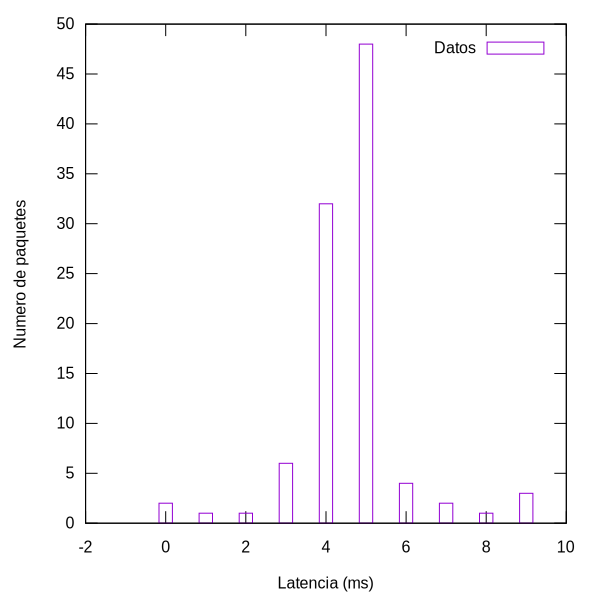

In [371]:
%%gnuplot
set xlabel 'Latencia (ms)'
set ylabel 'Número de paquetes'
plot "/tmp/localhost_histogram.dat" title 'Datos' with histogram 

En caso de querer verlo mediante una ventana emergente, se debe usar <i>%gnuplot qt</i> al que se puede acompañar con un tamaño recomendado. Posteriormente, se vuelve a llamar a la celda mágica de gnuplot.

In [74]:
%gnuplot qt size 600,600 

In [75]:
%%gnuplot
plot "/tmp/localhost_histogram.dat" with histogram 

Dependiendo de la situación se obtendrán distintos resultados. Lo ideal es que la latencia fuera constante. Dado que esto no es posible, la siguiente situación ideal es que se presente una distribución con un valor central notorio.

Se procede a visualizar si existe algún modelo que explique la latencia de forma probabilística. Para ello se estudiará el ajuste de los datos del histograma 


Se probarán las siguientes distrubuciones:


1. **Distribución normal:** su función de densidad es:

    $$\dfrac{1}{\sigma \sqrt{2\pi}}e^{-\dfrac{1}{2}\left(\dfrac{x-\mu}{\sigma} \right)^2}$$



2. **Distribución normal logarítmica:** su función de densidad es:

    $$ \dfrac{1}{x\sigma_L \sqrt{2\pi}}e^{\dfrac{-(\ln(x)-\mu_L)^2}{2 \sigma_{L}^{2}}}$$

 donde: $\mu_L = \log \left(\dfrac{\mu^2}{\sqrt{\mu^2 + \sigma^2}}\right)$ $\quad$ y $\quad$ $\sigma_{L}^{2}=\log \left(1 + \dfrac{\sigma^2}{\mu^2} \right)$
 


**Nota** Se recuerda que la integral impropia (área de toda la curva) de la función de densidad es igual a 1. Esto es:

$$ \int_{-\infty}^{\infty} f(x)dx=1$$


Con motivo de intentar visualizar los histogramas de una forma más adecuada, se utilizará la regla de **Freedman-Diaconis**, la cual dicta que el tamaño de las barras es:

$$anchura = 2 \dfrac{IQR(x)}{\sqrt[3]{x}}$$

donde $IRQ$ es el rango intercuartílico. No obstante, esto no proporciona el número de barras, para ello, partiendo de la anchura, se calcula el número de la forma:

$$num\_barras= \dfrac{max\{x\}-min\{x\}}{anchura}$$

Cargamos los datos en un vector de numpy

In [374]:
data=np.loadtxt("/tmp/localhost_latencies.dat")

Definimos las funciones e importamos las librerias necesarias

In [22]:
import scipy.stats as st
from scipy.stats import norm
from scipy.stats import lognorm
import math

def freedman_num_bins(data):
    w_bins = 2*st.iqr(data) / (len(data) ** (1. / 3))
    n_bins = (max(data)-min(data)) / w_bins
    return round(n_bins)

def print_distribution(data, distribution):
    space = np.linspace(min(data),max(data), len(data))
    if (distribution == "normal"):
        param = norm.fit(data)
        normal_pdf = norm.pdf(space, param[0], param[1])
        plt.plot(space, normal_pdf, 'g',linewidth=2)
        
    elif (distribution == "lognormal"):
        param = lognorm.fit(data)
        lognormal_pdf=lognorm.pdf(space, param[0], param[1], param[2])
        #lognormal_pdf=lognorm.pdf(space, param[0], loc=param[1], scale=param[2])
        plt.plot(space, lognormal_pdf, 'r',linewidth=2)
        
    elif (distribution == "gamma"):
        param = st.gamma.fit(data)
        gamma_pdf=st.gamma.pdf(space, param[0], param[1], param[2])
        plt.plot(space, gamma_pdf, 'y',linewidth=2)
        
    elif (distribution == "beta"):
        param = st.beta.fit(data)
        beta_pdf=st.beta.pdf(space, param[0], param[1], param[2], param[3])
        plt.plot(space, beta_pdf, 'o',linewidth=1)

Antes de proceder, se realizarán algunos ajustes:


1. Normalizar el histograma. De esta forma $\sum_{i=1}^{b} h_i = 1$ donde $b$ es el número de barras y $h_i$ la altura de la barra i-ésima


2. Los datos están en segundos. Pasaremos dicho valor a milisegundos. De lo contrario, la función de densidad de la distribución normal logarítmica se verá comprometida por el efecto de los valores decimales.

In [2]:
# # Ajuste para la normlaización del histograma

data_ms = data[:]*1000 # a ms
weights = np.ones_like(data_ms) / len(data_ms)

# Podemos usar los datos originales, dado que 
# se ha aplicado un homeomorfismo

n_bins = freedman_num_bins(data)

# Se pinta el histograma

plt.hist(data_ms, bins=math.ceil(n_bins), alpha=0.75, weights=weights)

# Se pintan las funciones de densidad 

print_distribution(data_ms, "normal")
print_distribution(data_ms, "lognormal")
print_distribution(data_ms, "gamma")

plt.show()

NameError: name 'data' is not defined

De forma experimental, suele verse que las tres funciones de densidad son "próximas" entre sí. No obstante, el modelo más simple es el dado por una distribución normal. 

49.60628287400623
Figure(3000x1500)
Figure(3000x1500)
(0.12040396126827643, 10.149896075857443, 9.24793558598116)


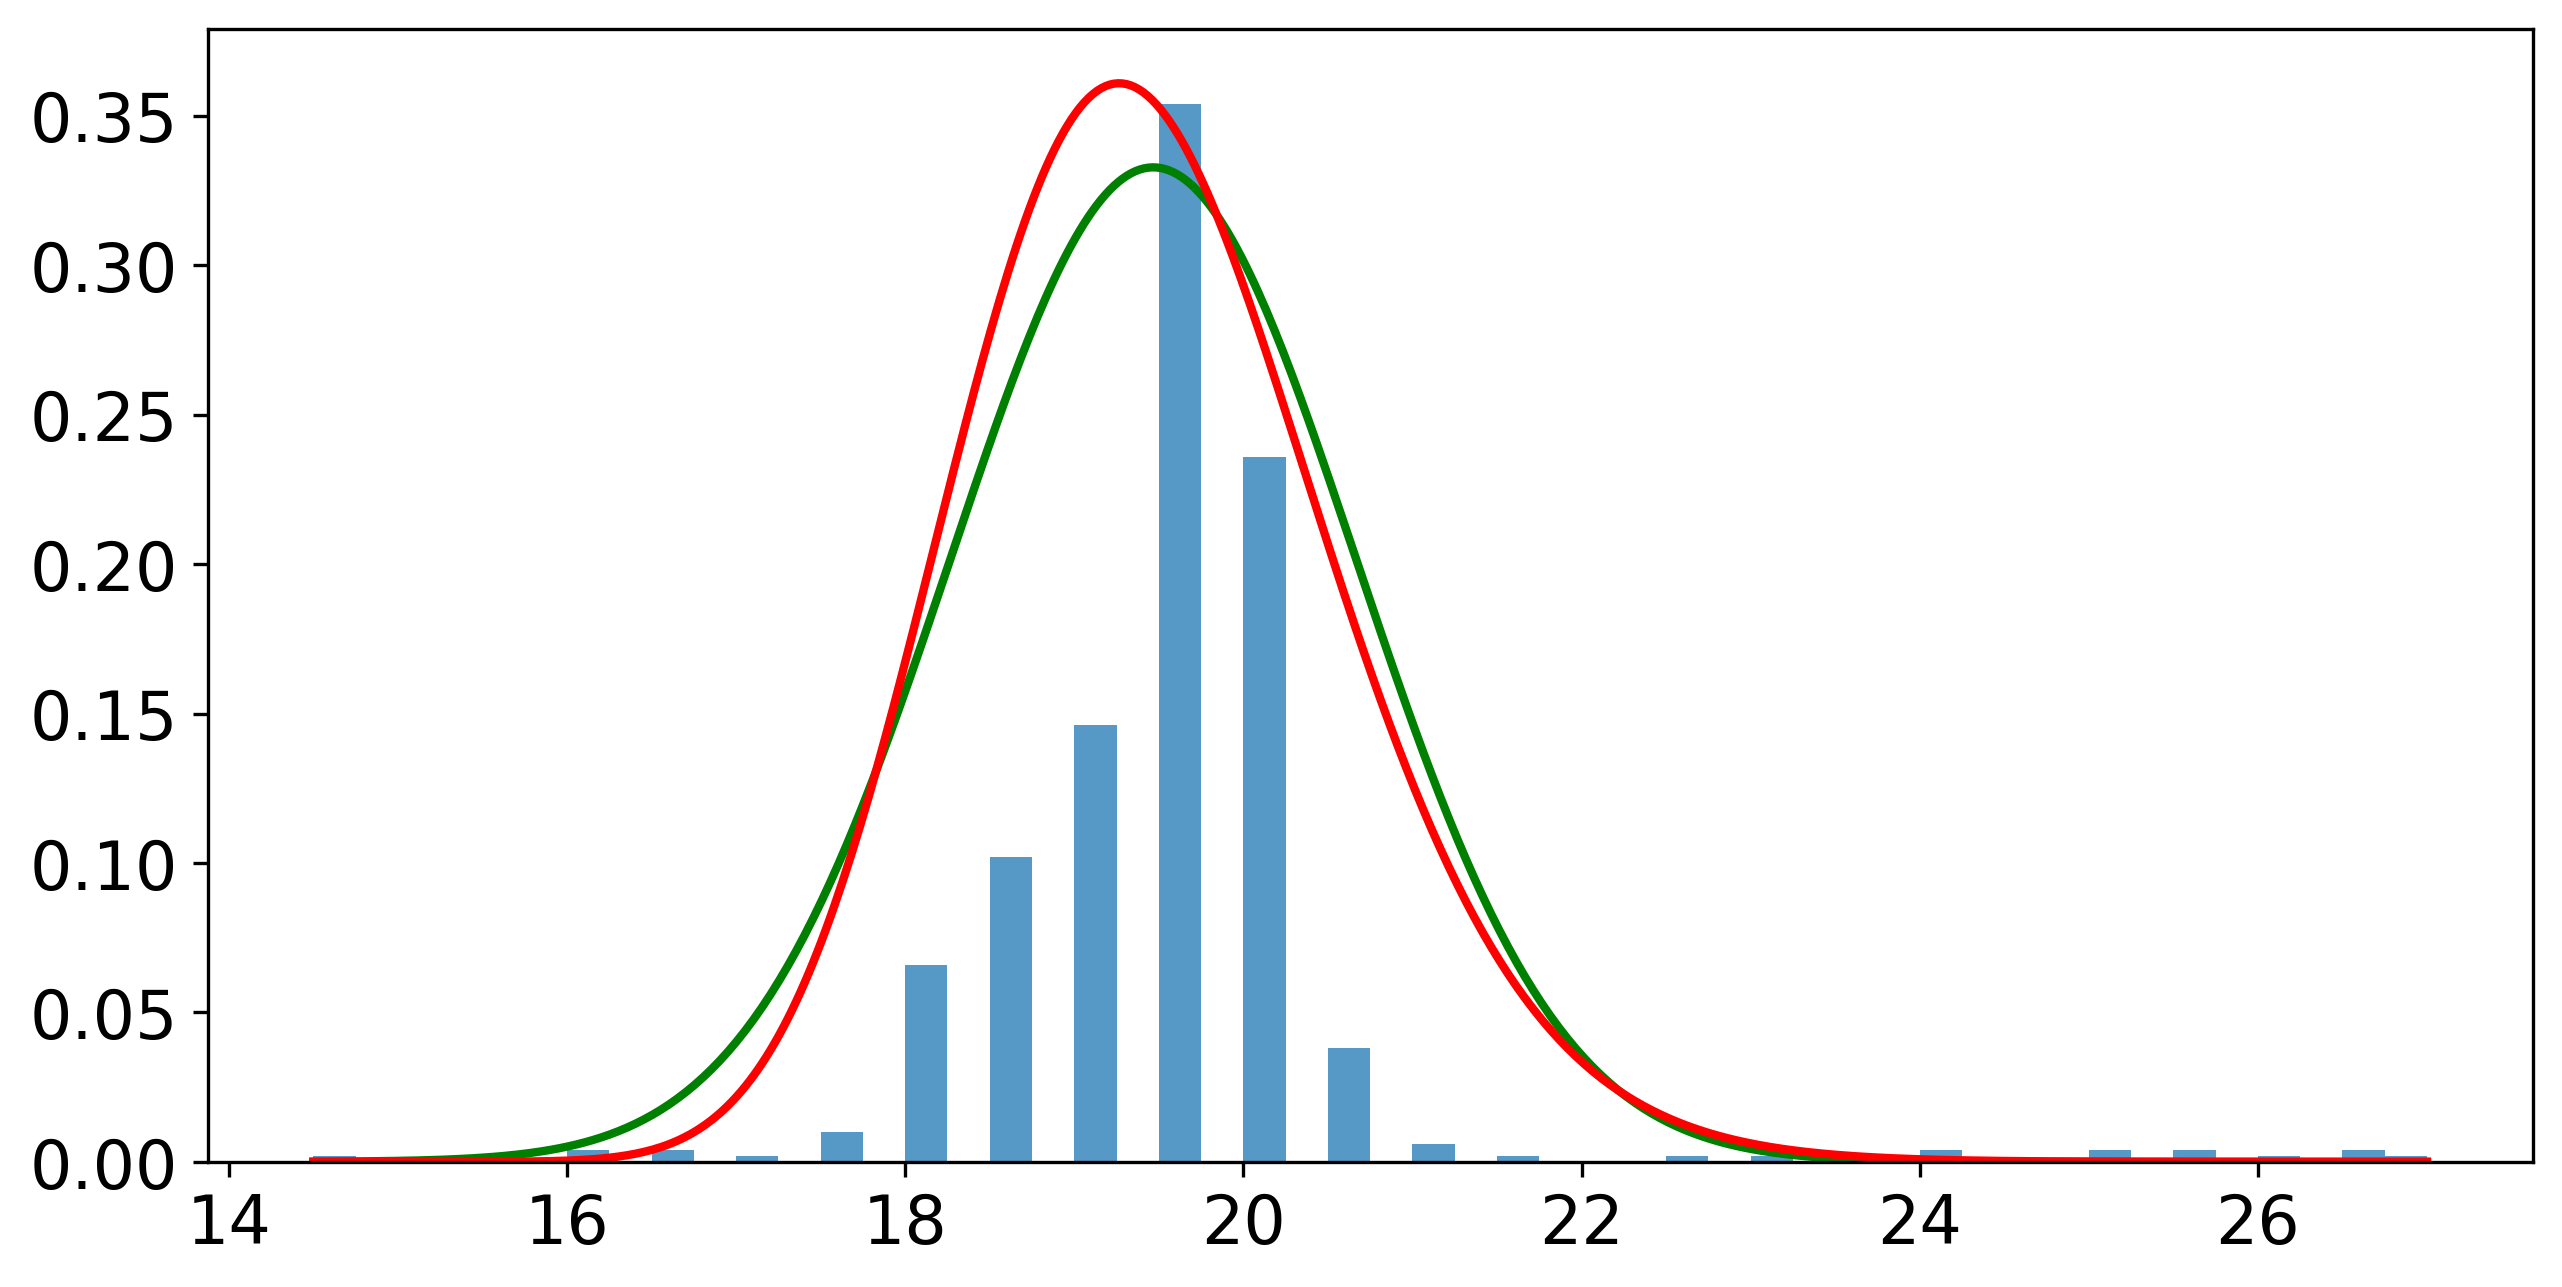

In [328]:
import scipy.stats as st
from scipy.stats import norm
from scipy.stats import lognorm
import math


# Ajuste para la normlaización del histograma
data2=data[:]*1000
weights = np.ones_like(data2) / len(data2)

# Anchura de las clases del histograma
# se seguirá la regla de freedman di

w_bins = 2*st.iqr(data2) / (len(data2) ** (1. / 3))

# Número de componentes del histograma

n_bins = (max(data2)-min(data2)) / w_bins

fig = plt.figure()
ax = fig.gca()

plt.hist(data2, bins=math.ceil(n_bins), alpha=0.75, weights=weights)

# plt.rcParams.update({'font.size': 16})
# plt.rcParams['figure.figsize'] = [10, 5]
# plt.rcParams['figure.dpi']=300


# ajustamos 

def print_distribution(data, distribution):
    space = np.linspace(min(data),max(data), len(data))
    print(fig)
    if (distribution == "normal"):
        param = norm.fit(data)
        normal_pdf = norm.pdf(space, param[0], param[1])
        plt.plot(space, normal_pdf, 'g',linewidth=2)
        
    elif (distribution == "lognormal"):
        param = lognorm.fit(data)
        lognormal_pdf=lognorm.pdf(space, param[0], loc=param[1], scale=param[2])
        plt.plot(space, lognormal_pdf, 'r',linewidth=2)
        

print_distribution(data2, "normal")
print_distribution(data2, "lognormal")

plt.show()





3.5672678621039933 19.86
1.2717999980636092 2.9887076586170265
(0.12040396126827643, 10.149896075857443, 9.24793558598116)


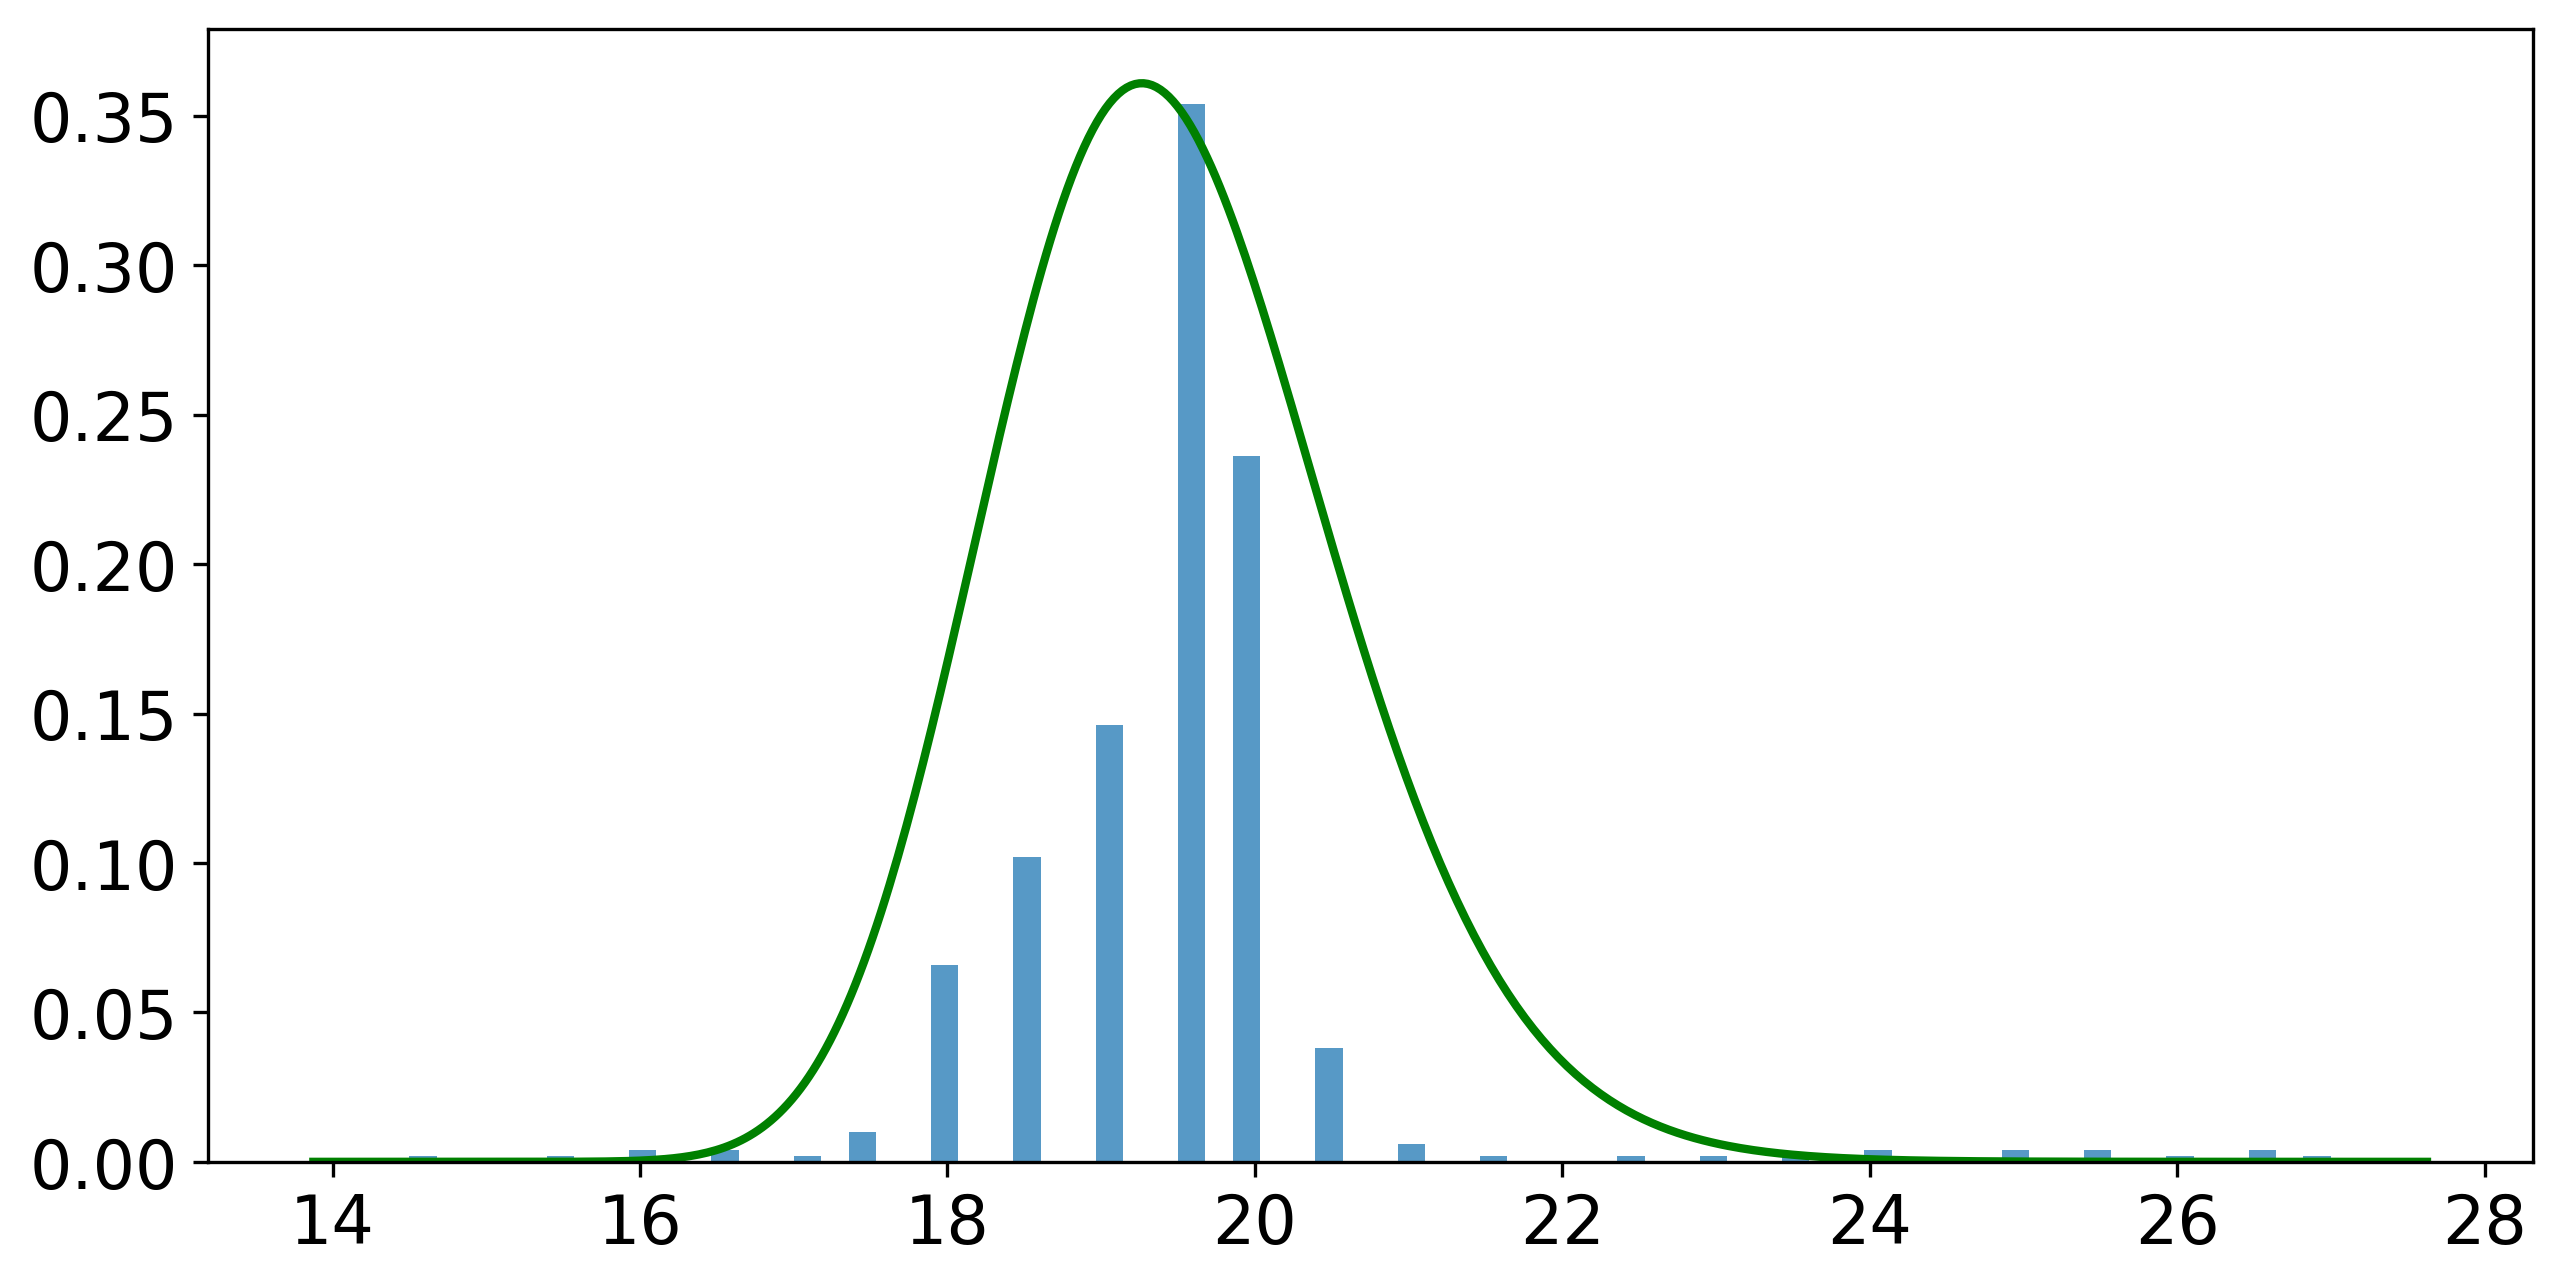

In [201]:
import scipy.stats as st
from scipy.stats import norm
from scipy.stats import lognorm
import math
# Fit a normal distribution to the data:
data2=data[:]*1000

weights = np.ones_like(data2) / len(data2)
plt.hist(data2, bins=70, alpha=0.75, weights=weights)

sigma = np.std(data2)
mu = np.mean(data2)



xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, len(data2))
p = norm.pdf(x, mu, sigma)
#plt.plot(x, p, 'k', linewidth=2)
print(std, mean)
print(math.log(std),math.log(mean))

sigma_log=2.97
mu_log=0.1781

dist=lognorm([sigma],loc=mu)

# l = lognorm.pdf(x, 2.97, 0.01781 )
#plt.plot(x, dist.pdf(x), 'g', linewidth=2)
pdf = lognorm.pdf(x, sigma, loc=mu, scale=1)
param=lognorm.fit(data2)
pdf_fit=lognorm.pdf(x, param[0], loc=param[1], scale=param[2])
print(param)
plt.plot(x, pdf_fit, 'g', linewidth=2)



param_gamma=st.gamma.fit(data2)
gamma_pdf=st.gamma.pdf(x,param_gamma[0], loc=param_gamma[1], scale=param_gamma[2])
# std=math.log(std)
#plt.plot(x, gamma_pdf, 'r', linewidth=2)



# plt.hist(data, bins='fd', density=True, stacked=True, alpha=0.75)
# mu, sigma = st.norm.fit(data)

#mu, sigma = scipy.stats.norm.fit(data)

#best_fit_line = scipy.stats.norm.pdf(bins, mu, sigma)

#plt.plot(bins, best_fit_line)

# xmin, xmax = plt.xlim()
# x = np.linspace(xmin, xmax, len(data))
# p = norm.pdf(x, mu, sigma)
# plt.plot(x, p, 'k', linewidth=2)
# title = "Fit results: mu = %.2f,  std = %.2f" % (mu, sigma)
# plt.title(title)
plt.show()
# print(weights)


## Caracterización de la latencia remota

Se repite el mismo procedimiento, pero usando la dirección IP publica

In [ ]:
83.34.89.33

In [114]:
!ping 83.34.89.33 -c 500 -s 512 > /tmp/ping-512b-publica.dat

In [6]:
!ping 217.216.135.188 -c 100 -s 1024 > /tmp/ping-1024b-publica.dat

In [9]:
!export LC_NUMERIC=en_US.UTF-8 # Use "." instead of "," for the decimal separator
!grep from < /tmp/ping-1024b-publica.dat | cut -f 4 -d "=" | cut -f 1 -d " " | awk '{print $1/2}' > ~/Desktop/public_latencies.dat

In [7]:
!echo "Wepale" >> ~/Desktop/wepale 

Realizamos la caracterizaciones de los datos obtenidos

In [17]:
import numpy as np 
from scipy import stats 
latencies = np.loadtxt("/home/cobeguel/Desktop/public_latencies.dat") 
average_latency = np.average(latencies) 
print("average latency =", average_latency) 
max_latency = np.max(latencies) 
min_latency = np.min(latencies) 
maximum_absolute_deviation = max(max_latency - average_latency, average_latency - min_latency) 
print("maximum absolute deviation (jitter)=", maximum_absolute_deviation) 
correlation_coefficient = stats.pearsonr(latencies, np.roll(latencies, 1))[0] 
print("Pearson correlation coefficient =", correlation_coefficient) 
if correlation_coefficient < 0: 
  print("Correlation coefficient < 0: use 0 (no correlation between RTT samples) in your experiments") 
histogram = np.histogram(latencies) 
np.savetxt("/tmp/localhost_histogram.dat", histogram[0])

average latency = 31.710500000000003
maximum absolute deviation (jitter)= 6.439499999999995
Pearson correlation coefficient = -0.03945695008078522
Correlation coefficient < 0: use 0 (no correlation between RTT samples) in your experiments


Se muestra el histograma usando gnuplot

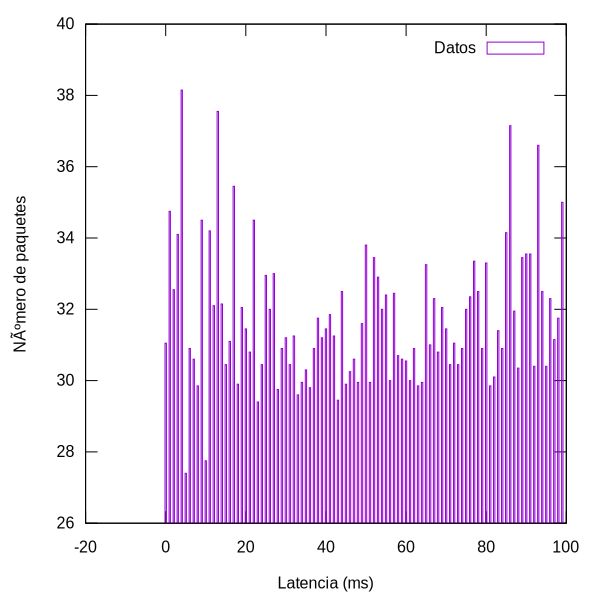

In [19]:
%%gnuplot
set xlabel 'Latencia (ms)'
set ylabel 'Número de paquetes'
plot "/home/cobeguel/Desktop/public_latencies.dat" title 'Datos' with histogram

Se realiza la caracterización de la distribución. Primero cargamos de nuevo los datos en un nuevo array de numpy

In [20]:
data_remote=np.loadtxt("/home/cobeguel/Desktop/public_latencies.dat")

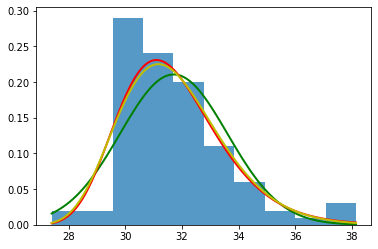

In [33]:
# # Ajuste para la normalización del histograma

data_ms = data_remote[:]# *1000 # a ms
weights = np.ones_like(data_ms) / len(data_ms)

# Podemos usar los datos originales, dado que 
# se ha aplicado un homeomorfismo

n_bins = freedman_num_bins(data_remote)

# Se pinta el histograma

plt.hist(data_ms, bins=math.ceil(n_bins), alpha=0.75, weights=weights)

# Se pintan las funciones de densidad 

print_distribution(data_ms, "normal")
print_distribution(data_ms, "lognormal")
print_distribution(data_ms, "gamma")


plt.show()